In [1]:
import os
from PIL import Image
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import scipy.io.wavfile as wavfile
import scipy
from scipy import signal
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
from IPython import display
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import EngFormatter

import soundfile as sf           
from scipy.signal import welch   
from scipy.io import wavfile
import scipy.signal as sps
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from sampling import module_functions
from IPython.display import Audio
from IPython import display
import torch.nn as nn
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as Fu

%matplotlib inline

#  La transformada continua de Fourier (FT)

> + En una dimensión como es el caso de señales de audio, el <span style="color:red">**par de transformadas de Fourier**</span> que consiste en la `transformada directa` y la `transformada inversa`, se definen como:

$$
\begin{align*}
X(\omega) = & \int_{-\infty}^{\infty} x(t)\cdot e^{-j\omega t} dt\quad \quad\quad{\text{(transformada directa)}}\\
x(t)      = & \,\frac{1}{2\pi}\int_{-\infty}^{\infty} X(\omega)\cdot e^{j\omega t} d\omega \quad \,{\text{(transformada inversa)}}
\end{align*}
$$

> + donde $j=\sqrt{-1}$, y la exponencial compleja: $e^{j\omega t}= \cos\omega t + j\sin\omega t$.

> + $x(t)\overset{\mathscr{F}}{\longleftrightarrow} X(\omega)$

> + O bien, como $\mathscr{F}\left\lbrace x(t) \right\rbrace = X(\omega)$ $\,\,$ y $\,\,$  $\mathscr{F^{-1}}\left\lbrace X(\omega) \right\rbrace = x(t)$

> + Tanto $x(t)$ como $X(\omega)$ son, en general, funciones de valor complejo.

## La transformada de Fourier en tiempo discreto (DTFT)

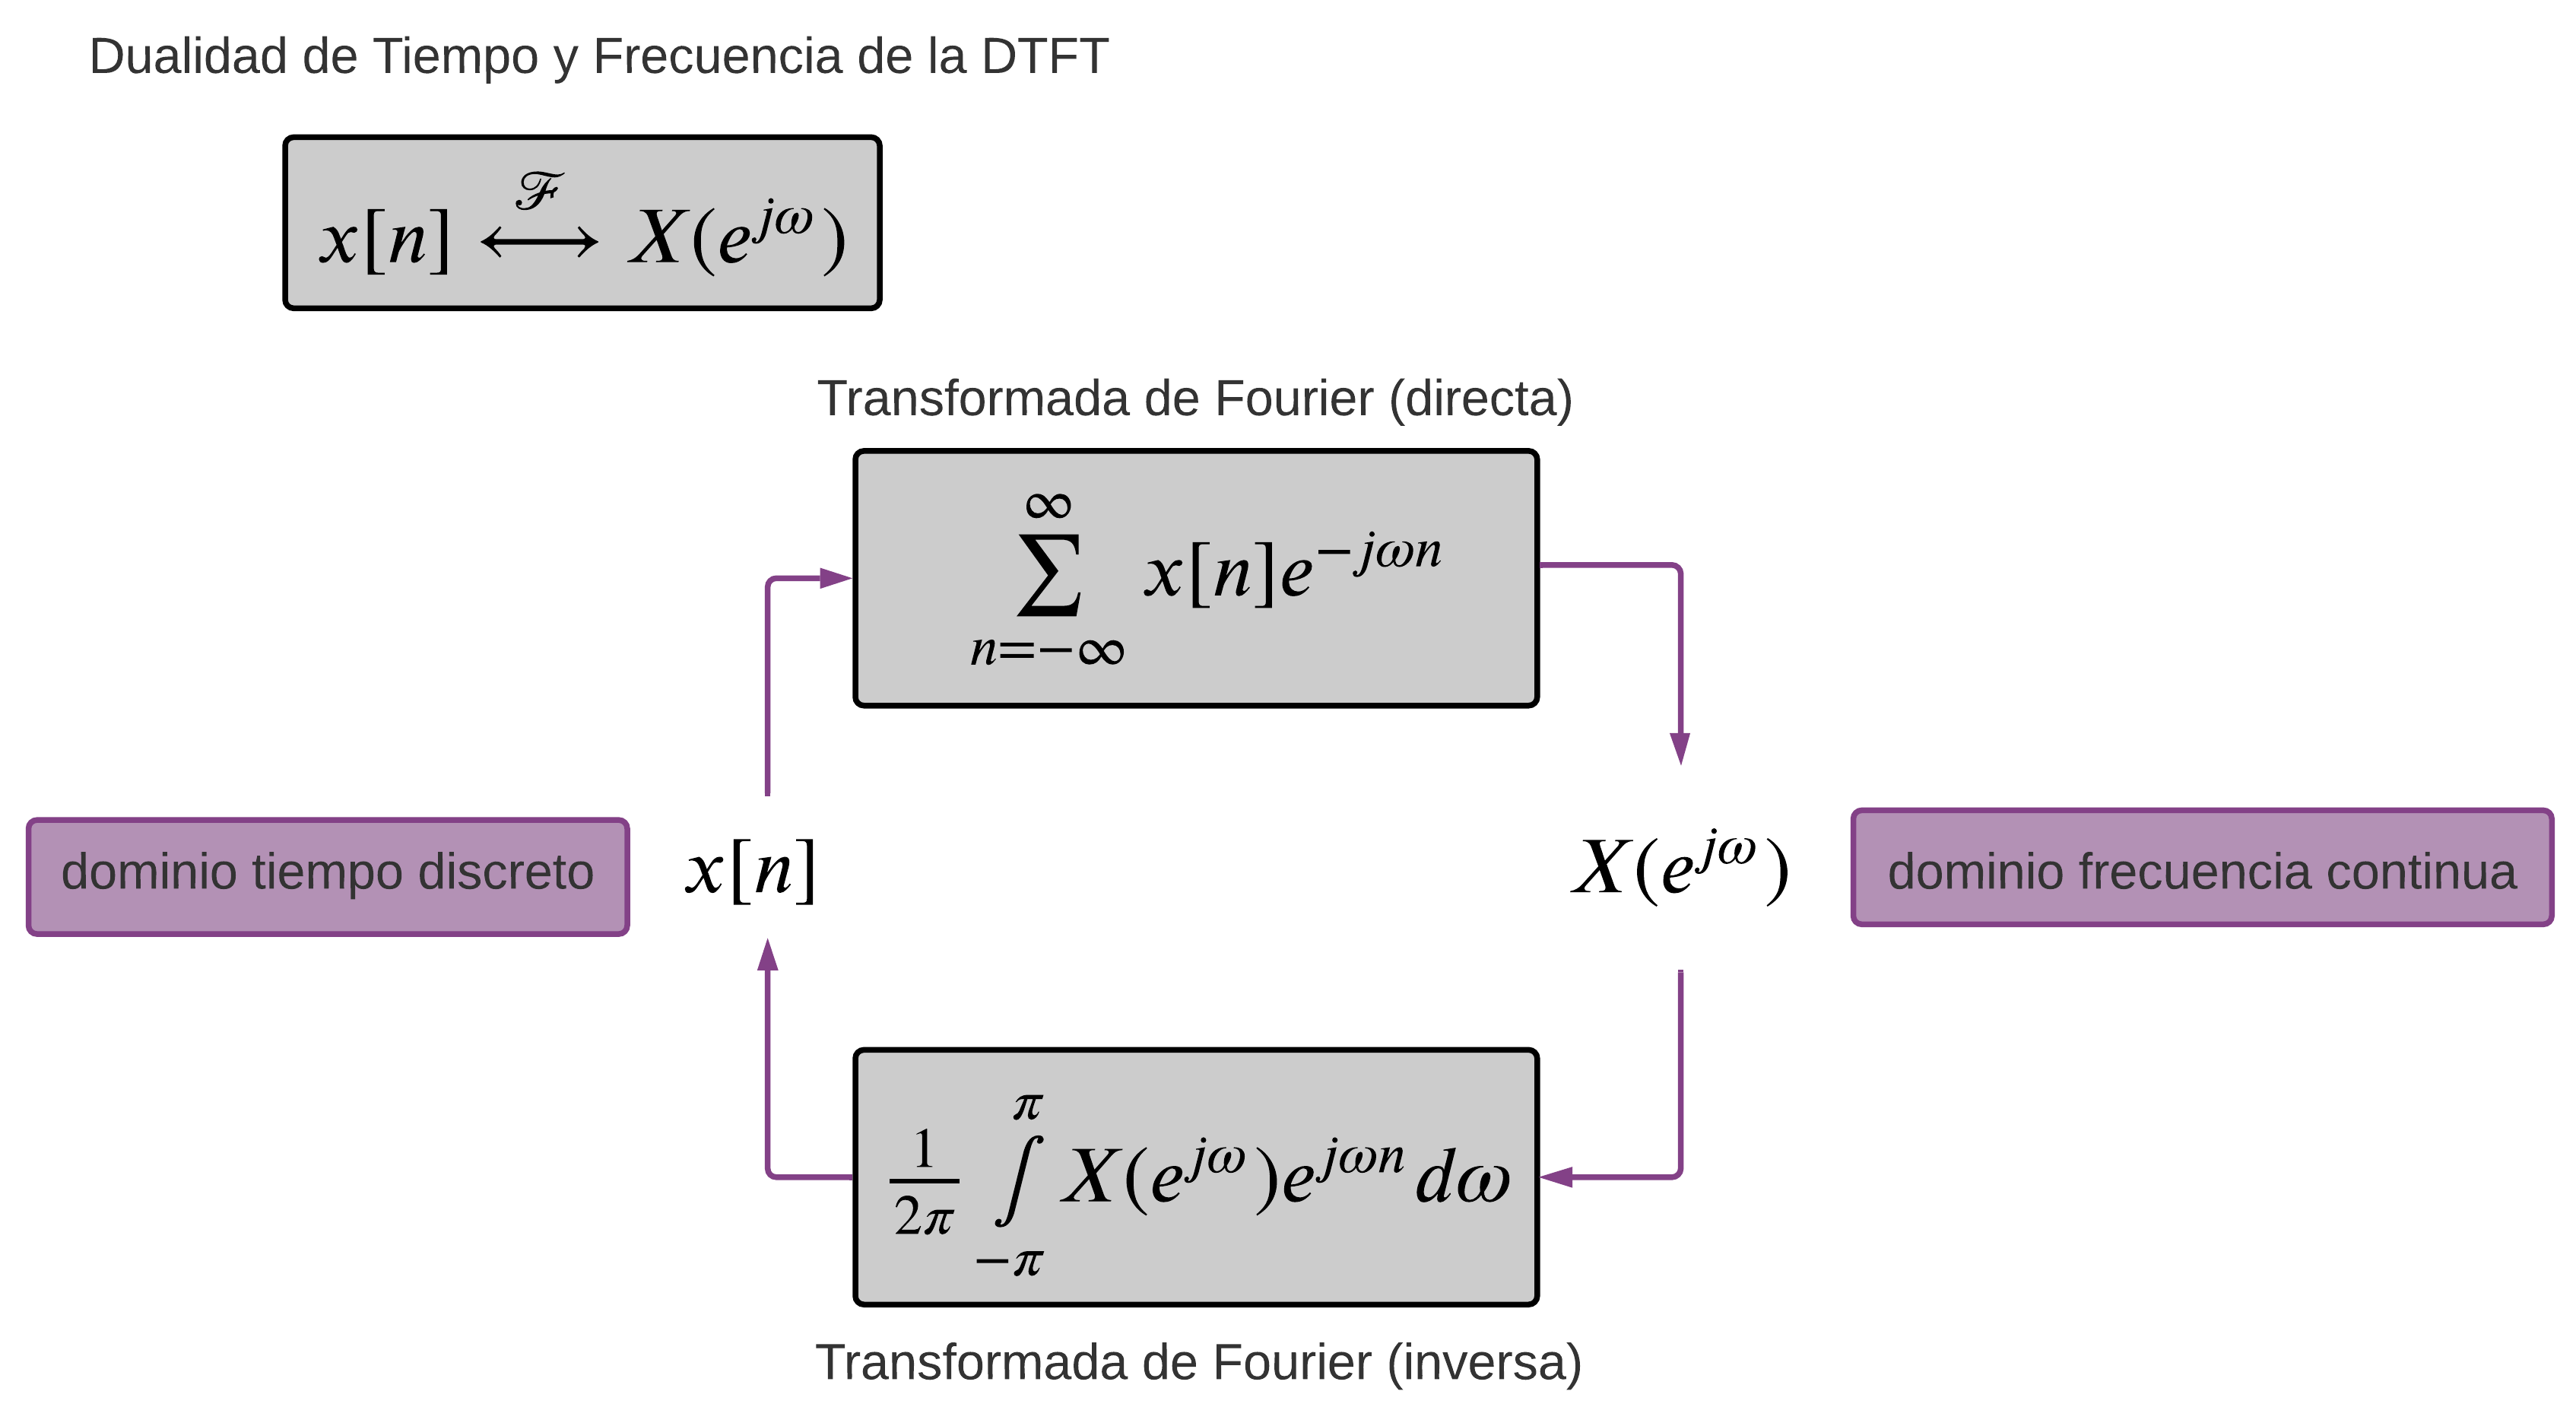

In [2]:
_SAMPLE_DIR_IMG  = "image_data"
img_path2 = os.path.join(_SAMPLE_DIR_IMG, "monodft.png")
os.makedirs(_SAMPLE_DIR_IMG, exist_ok=True)
display.Image(img_path2, width="700")

## La transformada de Fourier discreta (DFT)

> + Pero, si trabajamos sobre un computador, usamos la <span style="color:red">**Transformada de Fourier Discreta**</span>. 

> + Las ecuaciones para la DFT son muy similares a las de la transformada continua de Fourier.

> + En este caso, la DFT trabaja con señales de <span style="color:red">**duración finita**</span>, de duración $N$.

> + Análogamente, la <span style="color:red">**transformada discreta directa**</span> y la <span style="color:red">****transformada discreta inversa****</span>, se definen como:

$$
\begin{align*}
X[k] = & \sum_{n=0}^{N-1} x[n] \cdot W_N^{kn} \quad \quad\quad{\text{(transformada discreta directa)}}\\
x[n]      = & \,\frac{1}{N}\sum_{n=0}^{N-1} X[k]\cdot W_N^{-kn} \quad \,{\text{(transformada discreta inversa)}}
\end{align*}
$$

> + donde $x[n]$ es la señal de audio en tiempo discreto, de duración $N$ muestras, $X[k]$ es el <span style="color:red">**espectro discreto de la señal**</span> (con un número discreto de frecuencias), y $W_N=e^{-j\frac{2\pi}{N}}$.

## La trasformada rápida de Fourier (FFT)

> + La FFT es un algoritmo eficiente para calcular la DFT de una señal discreta.

> + Fue publicado por primera vez por **Cooley** (IBM) y **Tukey** (Princeton University) en 1965.

> + Sin embargo, la idea original se remonta a un artículo inédito de Gauss en 1805 [https://nonagon.org/ExLibris/gauss-fast-fourier-transform]. 

> + La FFT es considerada como uno de los algoritmos más importantes en computación científica.

> + El algoritmo de la FFT va dividiendo recursivamente la DFT, en DFTs más pequeños para acelerar el cálculo. 

> + Como resultado el tiempo de cómputo se reduce asombrosamente, ya que la cantidad de operaciones de la DFT original que es de un orden $N^{2}$, disminuye a un orden de ($N\cdot {\text{log}}_2{N}$) operaciones, donde $N$ es el número total de datos. 

> + La FFT es más eficiente si su **largo N** (se dice que $N$ es el largo de la FFT) es una potencia de dos: $N = 2^{L} \,\, {\text{elementos}}.$

> + La FFT la podemos aplicar al largo entero de la señal en el tiempo discreto, por lo que el largo de la FFT sería igual al largo de la señal. 

> + Sin embargo, ya que la FFT es más eficiente cuando su largo es una potencia de 2, se aplica una técnica muy clásica llamada **zero padding** que agrega ceros hasta que la señal llega a ser de un largo que es potencia de 2.

> + Por ejemplo, supongamos que $x[n]$ tiene largo 3: $x = [3.4, 2.56, 1.3]$, de tal manera que cambiamos $x[n]$ para que sea: $x = [3.4, 2.56, 1.3, 0.0]$, y aplicamos una FFT de largo 4.

> + Un gran PERO... es que si nuestra señal es muy larga, se vuelve extremadamente ineficaz hacer todo a la vez. No es práctico intentar hacer una FFT a un archivo de audio de la larga longitud. En ese caso, dividimos la señal en ventanas de un tamaño razonable, y realizamos una FFT en cada una de esas ventanas y promediamos los resultados.

> + La DFT nos proporciona información sobre un número <span style="color:red">**discreto de frecuencias**</span>, por lo que debemos determinar qué frecuencias son éstas.

> + Para esto, muestreamos una señal continua $x(t)$ a intervalos equidistantes espaciados $T$, generando una secuencia de valores muestreados.

> + El recíproco de este espaciamiento $T$, nos da la **tasa de muestreo**, o también llamada **frecuencia de muestreo:** 

$$
\begin{align*}
f_s &= \frac{1}{T}\quad \quad\quad{\text{(frecuencia de muestreo)}}
\end{align*}
$$

> + Para cualquier intervalo de muestreo $T$, existe la frecuencia $f_{max} $ llamada <span style="color:red">**frecuencia máxima de Nyquist**</span>:

$$
\begin{align*}
f_{max} &= \frac{f_s}{2}\quad \quad\quad{\text{(frecuencia de Nyquist)}}
\end{align*}
$$

> + La frecuencia máxima de Nyquist es la frecuencia más alta que puede ser representada por el proceso de muestreo a intervalos de $T$. 

> + Debemos muestrear la señal $x(t)$ al menos 2 veces la frecuencia más alta contenida en la señal.

> + Si, por ejemplo, $f_s$ es $1000$ Hz, la frecuencia máxima de Nyquist es 500 Hz.


## Supongamos una señal antes de pasar por un convertidor de análogo a digital:

> + La notación: tenemos la señal $\large x(t)$

In [3]:
filename       = "sandy-beach_.wav"
x, sample_rate = librosa.load(filename, sr=32000) 

N              = x.shape[0]
secs           = N/float(sample_rate)  
T              = 1.0/sample_rate
time_vector    = np.arange(0, secs, T)

X              = np.abs(fft(x))
X_side         = X[range(N//2)]

freqs          = fftfreq(x.size, time_vector[1] - time_vector[0])
fft_freqs      = np.array(freqs)
freqs_side     = freqs[range(N//2)]
fft_freqs_side = np.array(freqs_side)

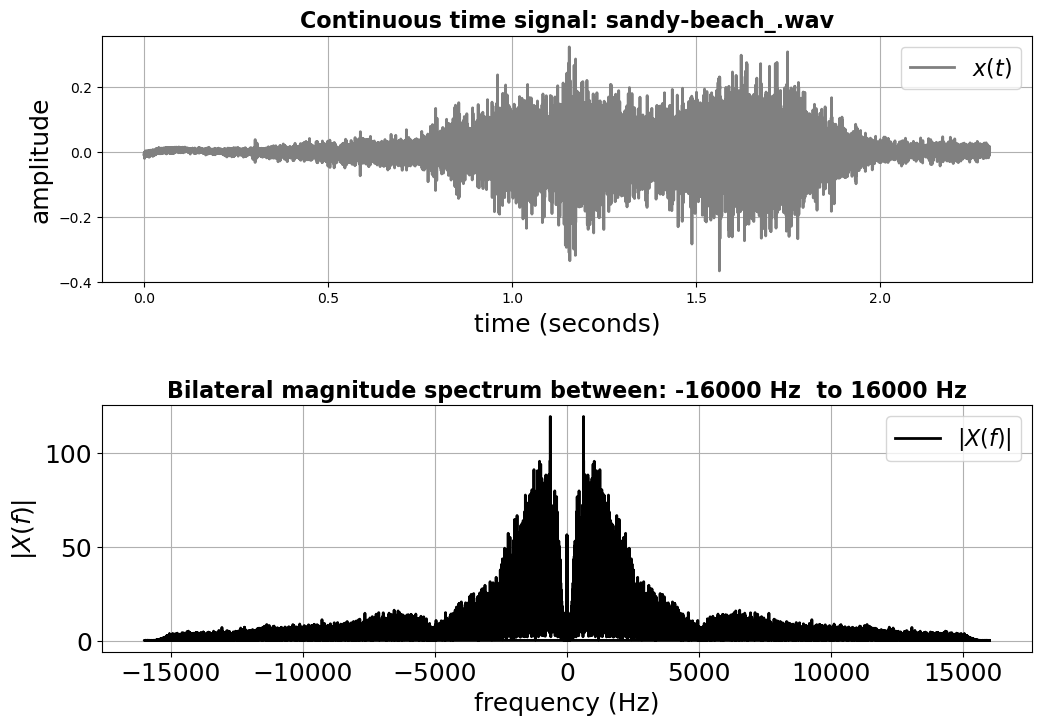

In [4]:
module_functions.plot_fft_custom(time_vector, x, filename, sample_rate, freqs, X)

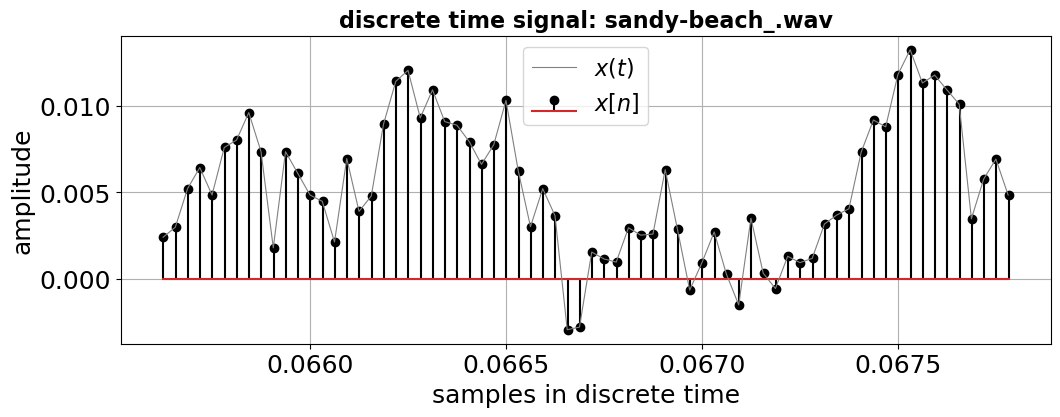

In [5]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 4)) 
fig.subplots_adjust(hspace=.5)

n   = np.linspace(0, secs, N)
on  = 2100
off = 2170

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
ax1.stem(n[on:off],x[on:off], linefmt='k', markerfmt='ko', label='$x[n]$')
ax1.plot(time_vector[on:off], x[on:off], 'grey', label = '$x(t)$', linewidth=0.8)
ax1.set_xlabel('samples in discrete time', fontsize=18)
ax1.set_ylabel('amplitude', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
ax1.set_title('discrete time signal: ' + str(filename), fontweight="bold", size=16)
ax1.legend()
ax1.grid()